# Dataprep

### Load data

In book2sentiment.ipynb for each of 129 books a sequence of sentiments was generated. This is the data we'll be working with.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from random import sample
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import sklearn.cluster as cl
from sklearn.metrics import davies_bouldin_score, silhouette_samples, silhouette_score

In [2]:
mypath = "data/parsed/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
books_data = np.array([np.loadtxt(mypath+file) for file in onlyfiles])   

In [3]:
max_len = np.max([book.shape[0] for book in books_data])
max_len

50497

### Unify data

Stretch sequences to the length of the longest sequence:

In [4]:
def stretch(max_len, arr):
    """
    Stretches an array to the max_len by
    inserting mean of neighbours enough times
    """
    diff = max_len-len(arr)
    inds = np.random.choice(len(arr)-1, diff, replace=True)
    inds.sort()
    inds = np.flip(inds, 0)
    for i in inds:
        ins_value = (arr[i] + arr[i+1]) / 2
        arr = np.concatenate((arr[:i+1], [ins_value], arr[i+1:]))
    return arr
        
books_data = np.array([stretch(max_len, i) for i in books_data])

All data is of the same length now:

In [5]:
np.unique([len(book) for book in books_data])

array([50497])

### Data processing

__smooth data:__

In [6]:
books_data = pd.DataFrame(data=books_data.T, columns=onlyfiles)
books_data.head()

,The Ragged Trousered Philanthropists - Robert Tressell.txt,Of Mice and Men - John Steinbeck.txt,Stephen-King-The-Long-Walk_-1979.txt,The Thirty-nine Steps - John Buchan.txt,KANE AND ABEL by JEFFREY ARCHER.txt,The Picture of Dorian Gray by Oscar Wilde.txt,Harry Potter and the Half-Blood - J.K. Rowling.txt,Andrzej Sapkowski - The Witcher 04 Time of Contempt - 2013.txt,Brave New World - Aldous Leonard Huxley.txt,Harry Potter and the Prisoner o - J.K. Rowling.txt,...,The Legend of Sleepy Hollow - Washington Irving.txt,Madame Bovary - Gustave Flaubert.txt,War and Peace - Unknown.txt,Salman Rushdie - Midnight's children.txt,Andrzej Sapkowski The Last Wish - DragonAshe.txt,Harry Potter and the Goblet of - J.K. Rowling.txt,The Last of the Mohicans - James Fenimore Cooper.txt,THE JUNGLE BOOK By Rudyard Kipling.txt,Great Expectations - Charles Dickens.txt,The Moonstone - Wilkie Collins.txt
0,-0.859222,0.731095,-0.953346,0.038804,-0.525339,0.940701,0.339183,-0.946042,0.912337,0.339183,...,0.12123,-0.628767,0.941668,-0.993096,0.554740,0.339183,-0.626545,-0.855626,0.614991,-0.525072
1,-0.613576,0.731062,-0.935052,0.038801,-0.446635,0.938145,-0.014374,-0.873778,0.907336,-0.367931,...,0.12123,-0.624691,0.777968,-0.992485,0.324072,0.162405,-0.626040,-0.854673,0.492126,-0.505429
2,-0.367931,0.731028,-0.916757,0.038798,-0.367931,0.935589,-0.367931,-0.801514,0.902335,-0.379372,...,0.12123,-0.620616,0.614268,-0.991875,0.093405,-0.014374,-0.625535,-0.853721,0.369260,-0.485787
3,-0.368701,0.730961,-0.880169,0.038791,-0.514474,0.930477,-0.212121,-0.656987,0.892333,-0.390814,...,0.12123,-0.612465,0.286868,-0.990654,-0.367931,-0.367931,-0.624524,-0.851816,0.123530,-0.446501
4,-0.369470,0.730827,-0.806992,0.038779,-0.661016,0.920253,-0.056311,-0.367931,0.872329,-0.413696,...,0.12123,-0.596162,-0.367931,-0.988211,-0.348397,-0.883867,-0.622504,-0.848006,-0.367931,-0.367931


Initial sentiment sequence looks very messy:

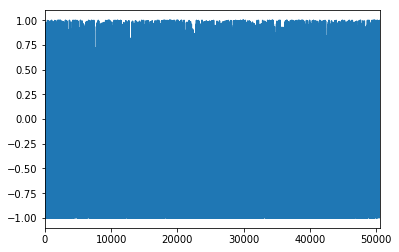

In [7]:
books_data['A Game Of Thrones - George R. R. Martin.txt'].plot()
plt.show()

But we can apply rolling average and see some patterns, like so:

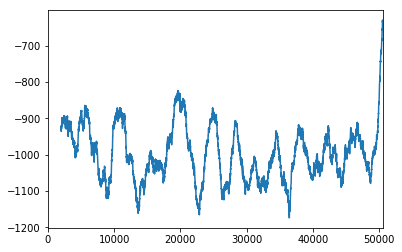

In [8]:
books_data['A Game Of Thrones - George R. R. Martin.txt'].rolling(2000).sum().plot()
plt.show()

Lets smooth it more:

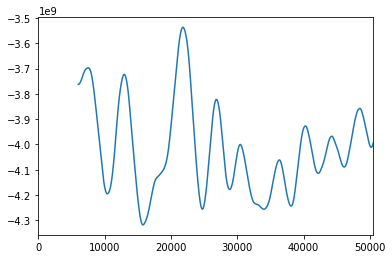

In [9]:
books_data['A Game Of Thrones - George R. R. Martin.txt'].rolling(2000).sum().rolling(2000).sum().rolling(2000).sum().plot()
plt.show()

now apply for all dataset:

In [10]:
smoothed_books = pd.DataFrame()
for book in onlyfiles:
    smoothed_books[book] = books_data[book].rolling(2000).sum().rolling(2000).sum().rolling(2000).sum()
smoothed_books = smoothed_books[6000:]
smoothed_books.head()

,The Ragged Trousered Philanthropists - Robert Tressell.txt,Of Mice and Men - John Steinbeck.txt,Stephen-King-The-Long-Walk_-1979.txt,The Thirty-nine Steps - John Buchan.txt,KANE AND ABEL by JEFFREY ARCHER.txt,The Picture of Dorian Gray by Oscar Wilde.txt,Harry Potter and the Half-Blood - J.K. Rowling.txt,Andrzej Sapkowski - The Witcher 04 Time of Contempt - 2013.txt,Brave New World - Aldous Leonard Huxley.txt,Harry Potter and the Prisoner o - J.K. Rowling.txt,...,The Legend of Sleepy Hollow - Washington Irving.txt,Madame Bovary - Gustave Flaubert.txt,War and Peace - Unknown.txt,Salman Rushdie - Midnight's children.txt,Andrzej Sapkowski The Last Wish - DragonAshe.txt,Harry Potter and the Goblet of - J.K. Rowling.txt,The Last of the Mohicans - James Fenimore Cooper.txt,THE JUNGLE BOOK By Rudyard Kipling.txt,Great Expectations - Charles Dickens.txt,The Moonstone - Wilkie Collins.txt
6000,-5.337457e+09,-4.780862e+09,-4.412920e+09,-4.823065e+09,-4.691661e+09,-4.732831e+09,-4.218782e+09,-4.218759e+09,-4.343719e+09,-3.962040e+09,...,-6.079855e+08,-4.580510e+09,-3.908920e+09,-4.496798e+09,-4.991958e+09,-4.065493e+09,-4.324909e+09,-4.159570e+09,-5.323934e+09,-4.671297e+09
6001,-5.337389e+09,-4.781240e+09,-4.413242e+09,-4.823195e+09,-4.691769e+09,-4.732605e+09,-4.218829e+09,-4.218787e+09,-4.343558e+09,-3.962097e+09,...,-6.058840e+08,-4.580306e+09,-3.908925e+09,-4.496855e+09,-4.992062e+09,-4.065289e+09,-4.325183e+09,-4.159781e+09,-5.324024e+09,-4.671489e+09
6002,-5.337321e+09,-4.781618e+09,-4.413564e+09,-4.823325e+09,-4.691877e+09,-4.732379e+09,-4.218875e+09,-4.218814e+09,-4.343396e+09,-3.962155e+09,...,-6.037829e+08,-4.580102e+09,-3.908930e+09,-4.496913e+09,-4.992166e+09,-4.065085e+09,-4.325458e+09,-4.159992e+09,-5.324115e+09,-4.671682e+09
6003,-5.337253e+09,-4.781996e+09,-4.413885e+09,-4.823455e+09,-4.691986e+09,-4.732153e+09,-4.218921e+09,-4.218841e+09,-4.343234e+09,-3.962212e+09,...,-6.016823e+08,-4.579897e+09,-3.908934e+09,-4.496971e+09,-4.992269e+09,-4.064881e+09,-4.325732e+09,-4.160202e+09,-5.324205e+09,-4.671874e+09
6004,-5.337185e+09,-4.782373e+09,-4.414206e+09,-4.823586e+09,-4.692094e+09,-4.731927e+09,-4.218967e+09,-4.218868e+09,-4.343071e+09,-3.962269e+09,...,-5.995822e+08,-4.579692e+09,-3.908938e+09,-4.497029e+09,-4.992373e+09,-4.064678e+09,-4.326007e+09,-4.160412e+09,-5.324295e+09,-4.672067e+09


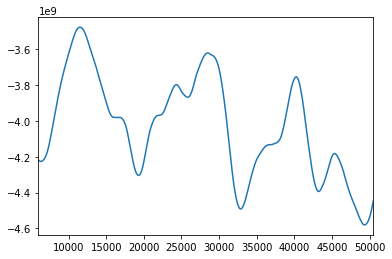

In [11]:
smoothed_books['Harry Potter and the Half-Blood - J.K. Rowling.txt'].plot()
plt.show()

In [12]:
train_books_data = smoothed_books.values.T

__shrink data__

Currently we have too much features for clustering algorithms to work quickly enough, so we can reduce them all to the length of 1000, like so:

In [13]:
shrinked_books = []
for book in smoothed_books.values.T:
    shrinked_books.append(np.array([np.mean(arr) for arr in np.array_split(book, 1000)]))
shrinked_books = np.array(shrinked_books)
shrinked_books.shape

(147, 1000)

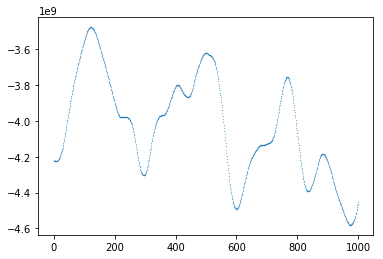

In [76]:
plt.scatter(list(range(1000)), shrinked_books[onlyfiles.index('Harry Potter and the Half-Blood - J.K. Rowling.txt')], s=0.05)
plt.show()

In [15]:
train_books_data = shrinked_books
train_books_data.shape

(147, 1000)

### visualize with t-sne

To understand how our sequences look in space we shrink them to 2 components(dimentions) with t-sne

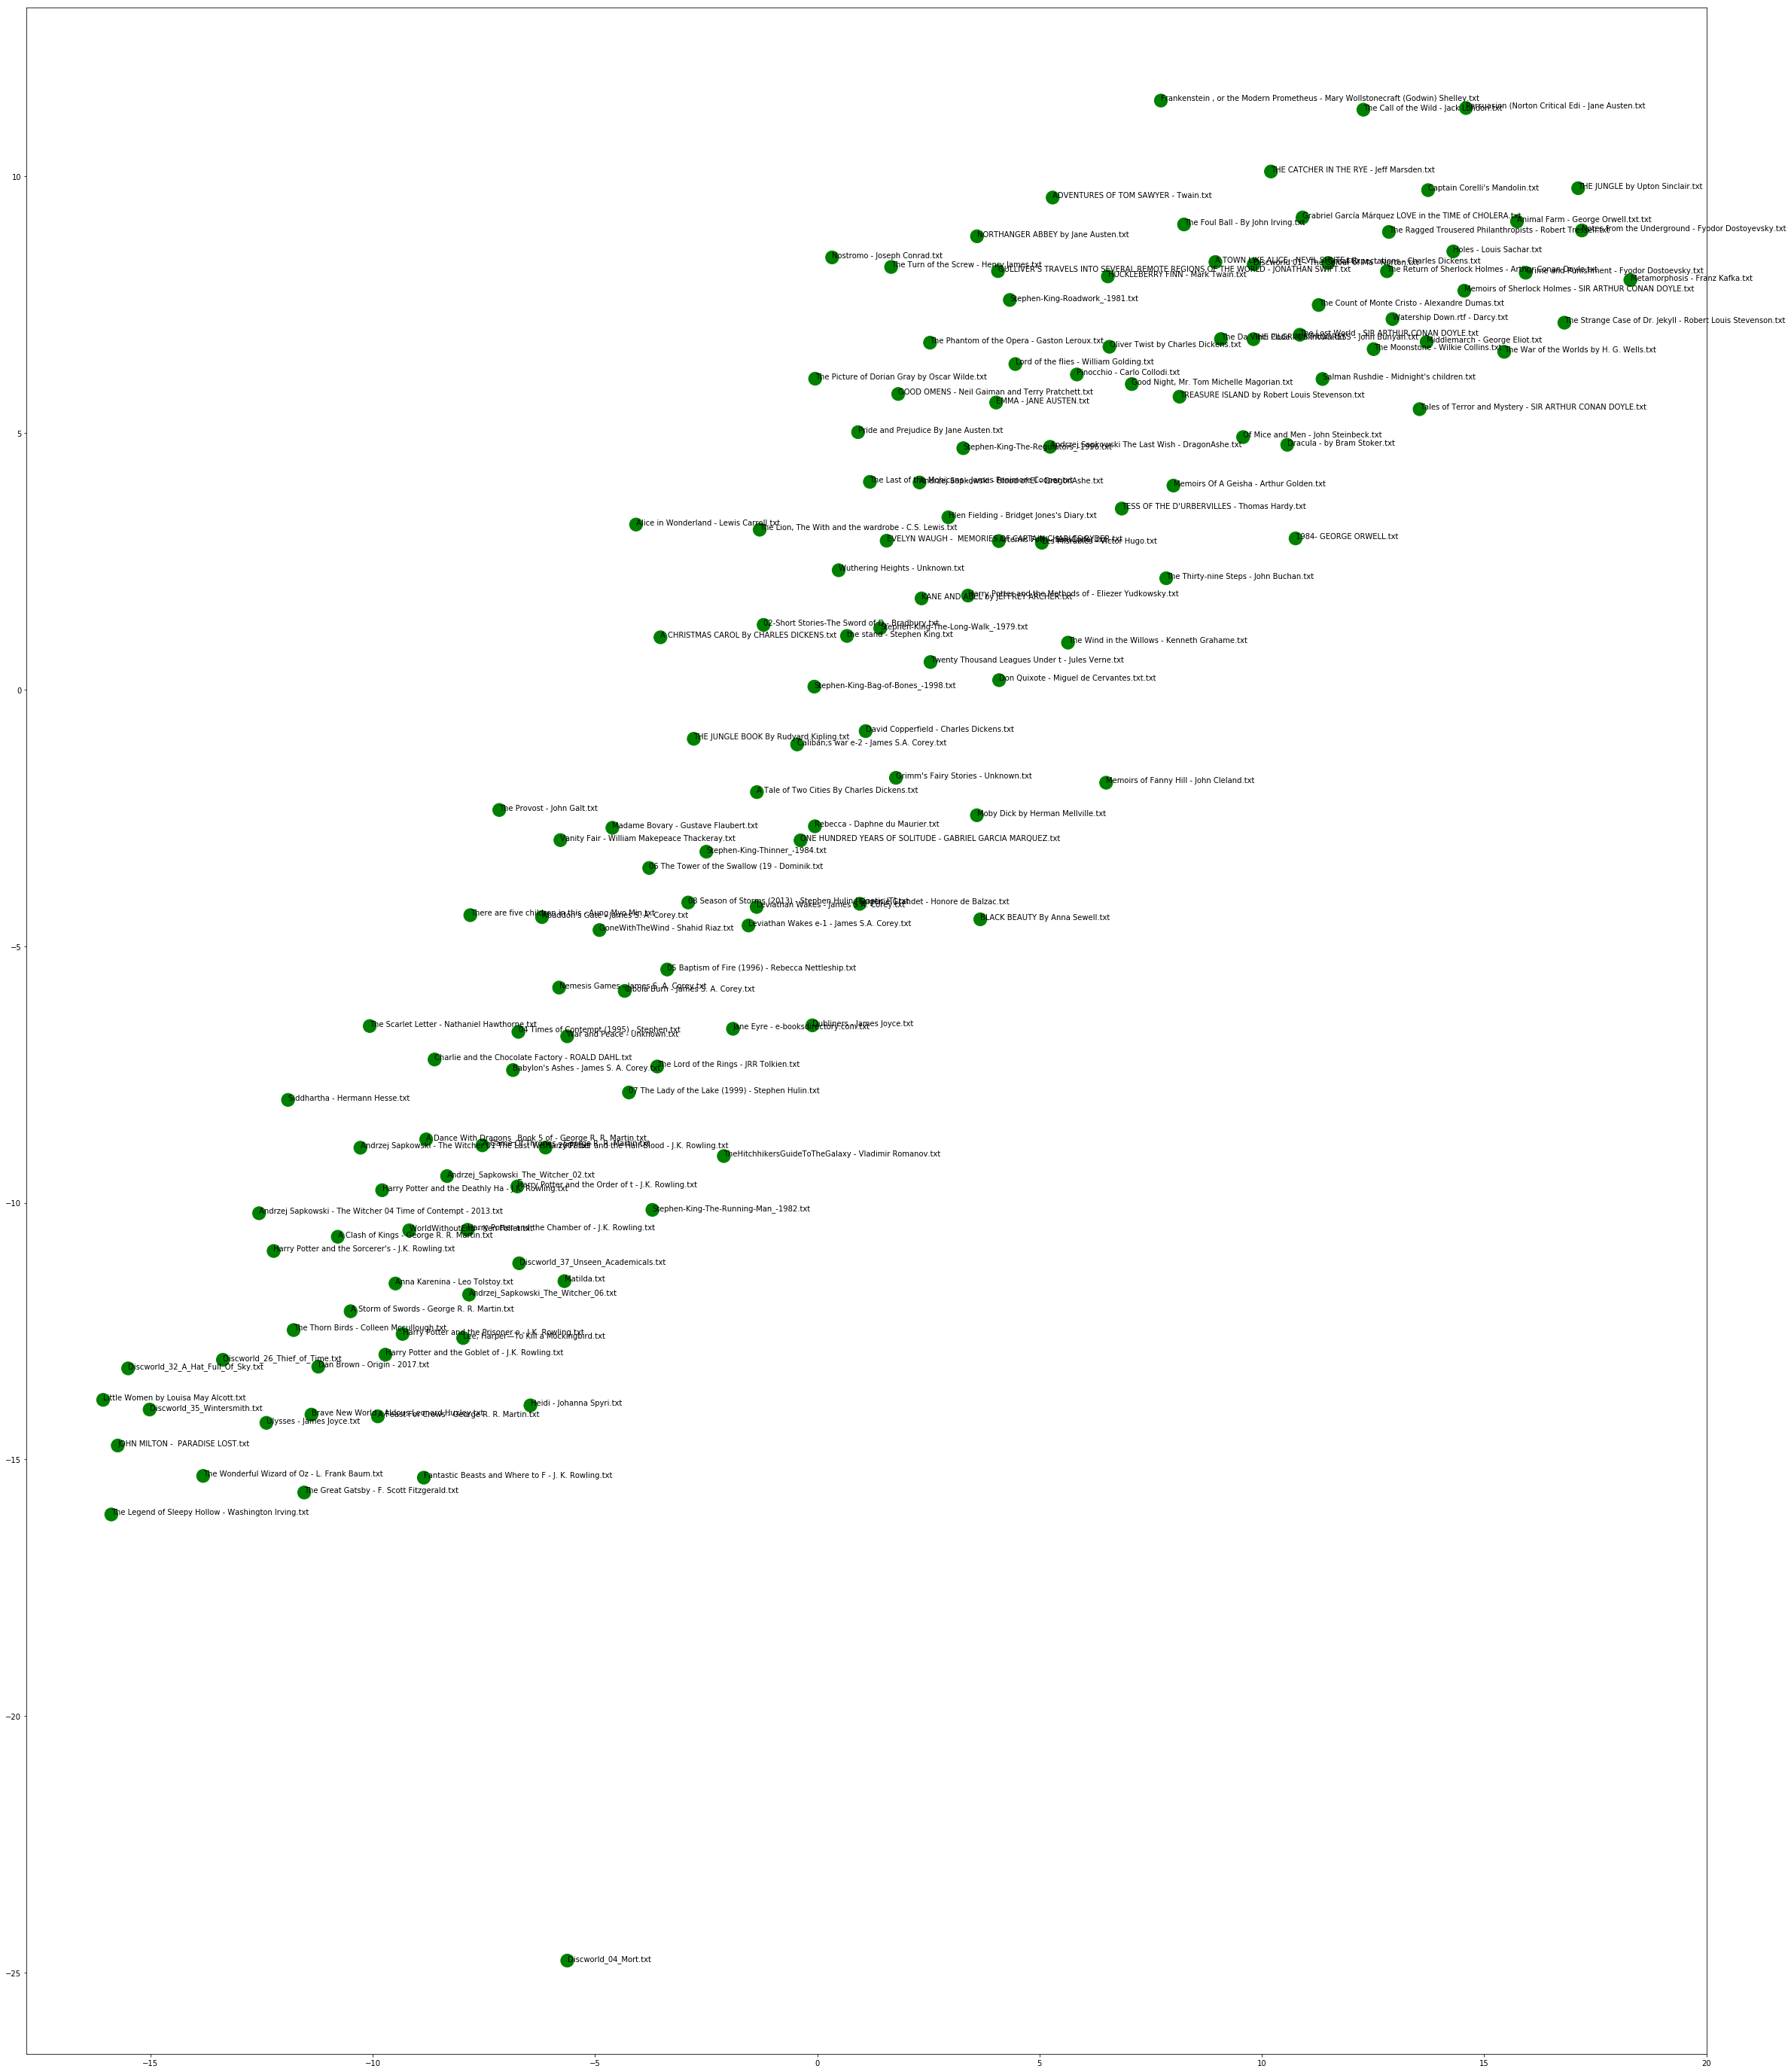

In [16]:
tsne = TSNE(n_components=2, n_iter = 300, random_state=0)
books_tsne = tsne.fit_transform(train_books_data)

def visualize_data(colors, annotate=False):
    """
    Provides 2 types of visualization of t-sne data:
    detailed with annotations, and simple scatterplot
    colors - list of colors to apply to points
    """
    point_s = 40
    if annotate:
        point_s=300
        plt.figure(figsize=(40,50))
        for i, name in enumerate(onlyfiles):
            plt.annotate(name, (books_tsne[i,0], books_tsne[i,1]))
    plt.scatter(books_tsne[:,0], books_tsne[:,1], s=point_s, c=colors);
    plt.show()
    
visualize_data(['green']*len(onlyfiles), annotate=True)

We can see that our data is pretty uniformely distributed within a long-shaped figure. Also we can see that one end of that figure contains more positive books, while the other contains more dark and pesimistic books.

# Clustering

Now let's try to cluster our sequences with different algorithms:

### K-means

#### Elbow method to determine number of clusters K:

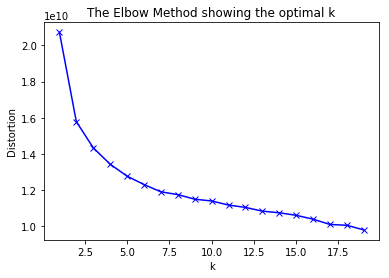

In [17]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = cl.KMeans(n_clusters=k, n_jobs=-1).fit(train_books_data)
    kmeanModel.fit(train_books_data)
    distortions.append(sum(np.min(cdist(train_books_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / train_books_data.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Elbow method showed that the optimal number of clusters is from 5 to 10. We have very different books in our dataset, so we assume there are like 7-10 clusters, so we chose K=9

In [18]:
K = 9

#### Cluster:

In [19]:
kmeans = cl.KMeans(n_clusters=K, random_state=0, n_jobs=-1).fit(train_books_data)
kmeans_pred = kmeans.predict(train_books_data)
kmeans_pred

array([8, 8, 3, 8, 3, 3, 1, 1, 1, 1, 8, 2, 1, 1, 1, 5, 7, 2, 5, 3, 5, 1,
       3, 1, 8, 0, 1, 5, 3, 5, 3, 5, 3, 2, 8, 5, 3, 2, 0, 5, 1, 1, 5, 3,
       8, 3, 3, 5, 8, 1, 0, 0, 8, 1, 1, 8, 3, 5, 0, 3, 0, 3, 1, 1, 5, 3,
       8, 5, 1, 3, 3, 1, 8, 7, 7, 8, 0, 1, 1, 8, 1, 3, 8, 5, 5, 5, 1, 1,
       5, 2, 1, 3, 8, 1, 3, 3, 3, 3, 8, 5, 8, 0, 3, 5, 8, 5, 1, 5, 0, 8,
       3, 3, 5, 3, 5, 3, 2, 5, 8, 5, 5, 5, 8, 3, 8, 5, 6, 5, 8, 5, 0, 3,
       8, 1, 7, 3, 3, 4, 5, 5, 8, 3, 1, 3, 5, 8, 8], dtype=int32)

In [20]:
kmeans.cluster_centers_

array([[-5.54073872e+09, -5.54267709e+09, -5.54392301e+09, ...,
        -5.66895159e+09, -5.66651513e+09, -5.66396295e+09],
       [-3.85222278e+09, -3.85306351e+09, -3.85384658e+09, ...,
        -4.04281810e+09, -4.04122912e+09, -4.03927981e+09],
       [-3.30542553e+09, -3.30573511e+09, -3.30592885e+09, ...,
        -3.13375081e+09, -3.10403996e+09, -3.07449200e+09],
       ...,
       [-4.33859336e+09, -4.36643038e+09, -4.39437405e+09, ...,
        -4.43746462e+09, -4.44651934e+09, -4.45523662e+09],
       [-2.87079254e+09, -2.86869995e+09, -2.86687337e+09, ...,
        -2.35792245e+09, -2.35247318e+09, -2.34702338e+09],
       [-4.94839179e+09, -4.95229143e+09, -4.95595416e+09, ...,
        -5.11925048e+09, -5.11664568e+09, -5.11393396e+09]])

In [21]:
def print_clusters(pred):
    K = len(np.unique(pred))
    clusters = [[name for name,l in zip(onlyfiles,pred) if l==label] for label in range(K)]
    for label in np.unique(pred):
        print('=========CLUSTER ' + str(label))
        print(clusters[label])
        
print_clusters(kmeans_pred)

=========CLUSTER 0
['Crime and Punishment - Fyodor Dostoevsky.txt', 'Metamorphosis - Franz Kafka.txt', 'Notes from the Underground - Fyodor Dostoyevsky.txt', 'The Strange Case of Dr. Jekyll - Robert Louis Stevenson.txt', 'Memoirs of Sherlock Holmes - SIR ARTHUR CONAN DOYLE.txt', 'The War of the Worlds by H. G. Wells.txt', 'Holes - Louis Sachar.txt', 'THE JUNGLE by Upton Sinclair.txt', 'Persuasion (Norton Critical Edi - Jane Austen.txt', 'Animal Farm - George Orwell.txt.txt']
=========CLUSTER 1
['Harry Potter and the Half-Blood - J.K. Rowling.txt', 'Andrzej Sapkowski - The Witcher 04 Time of Contempt - 2013.txt', 'Brave New World - Aldous Leonard Huxley.txt', 'Harry Potter and the Prisoner o - J.K. Rowling.txt', 'Heidi - Johanna Spyri.txt', "Harry Potter and the Sorcerer's - J.K. Rowling.txt", 'Harry Potter and the Chamber of - J.K. Rowling.txt', 'A Game Of Thrones - George R. R. Martin.txt', 'Matilda.txt', 'Anna Karenina - Leo Tolstoy.txt', 'WorldWithoutEnd - Ken Follet.txt', 'Andrzej 

Let's vizualize the results of clustering:

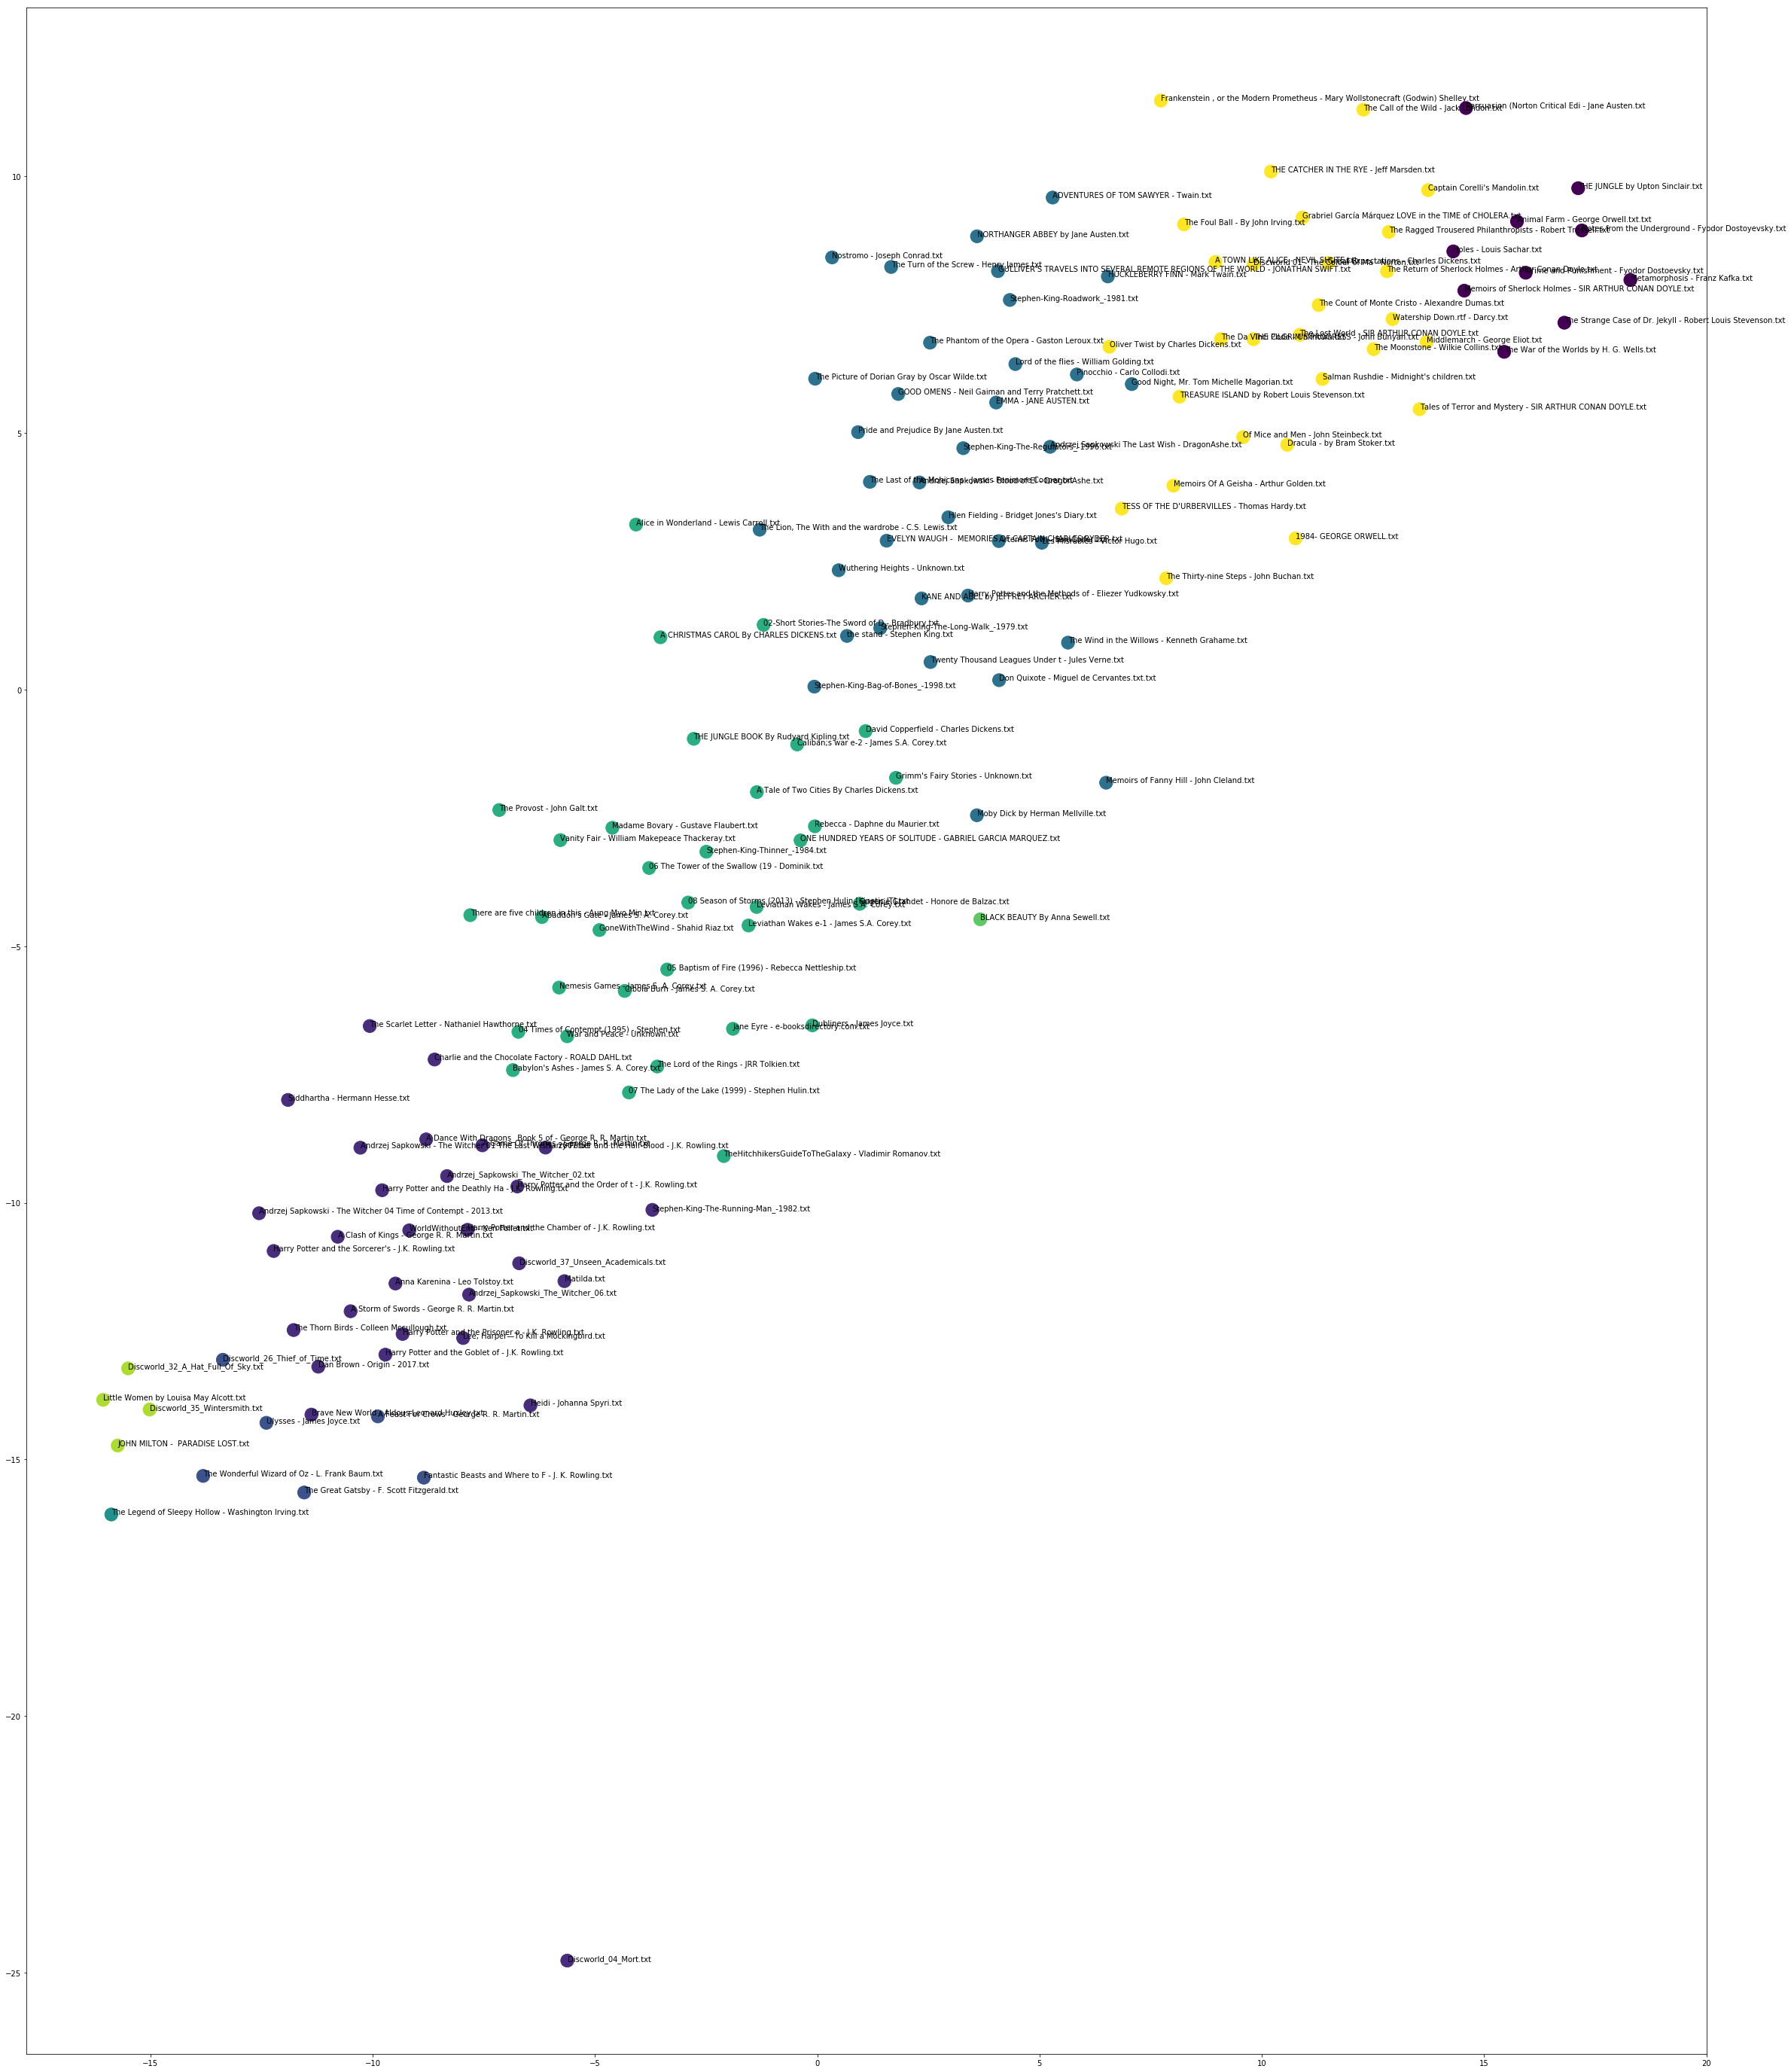

In [22]:
visualize_data(kmeans_pred, annotate=True)

Now these are our clusters. We can see, that books with similar plot are usually in one cluster, like Harry Potter books, most of which are in one cluster, or other cluster that gathers quite dark books together (Metamorposis, notes from underground, Jekyl&Hide, ...).

#### Evaluation

Obviously we can roughly estimateperformance ourselves as are familiar with a big part of the books in our dataset, but that is not always the case, which is why we need some metrics to evaluate our clustering model.

In [81]:
#  store results for future comparison
results = {'DBi':[], 'Silhouette coef':[], 'names':[]}

* DBi

The DB index captures the intuition that clusters that are (1) well-spaced from each other and (2) themselves very dense are likely a ‘good’ clustering. This is because the measure’s ‘max’ statement repeatedly selects the values where the average point is farthest away from its centroid, and where the centroids are closest together. As the DB index shrinks, the clustering is considered ‘better’.

In [82]:
results['DBi'].append(davies_bouldin_score(train_books_data, kmeans_pred))
results['names'].append('Kmeans')
davies_bouldin_score(train_books_data, kmeans_pred)

1.3481235857998475

* Silhouette Coefficient

The Silhouette Coefficient tells us how well-assigned each individual point is. If S(i) is close to 0, it is right at the inflection point between two clusters. If it is closer to -1, then we would have been better off assigning it to the other cluster. If S(i) is close to 1, then the point is well-assigned and can be interpreted as belonging to an ‘appropriate’ cluster.

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.

In [83]:
# average silhouette score
results['Silhouette coef'].append(silhouette_score(train_books_data, kmeans_pred))
silhouette_score(train_books_data, kmeans_pred)

0.14389059839189547

In [84]:
# solhouette score for each point
silhouette_samples(train_books_data, kmeans_pred)

array([ 2.97640040e-01,  1.27371685e-01,  1.25666680e-01,  2.71734546e-02,
        1.96980443e-01,  1.06986076e-01,  1.55814376e-01,  2.24971692e-01,
        1.27902054e-01,  2.46593546e-01,  3.09837744e-01, -1.86275547e-01,
        1.56820863e-01,  2.16078032e-01,  2.35077407e-01,  9.22786085e-02,
        4.34802443e-01, -1.05244206e-01,  2.10012099e-01,  1.76096736e-01,
        1.04418243e-01,  2.06476917e-01,  1.69890753e-01,  2.15275212e-01,
        9.41694778e-02,  2.11178808e-01,  3.18143230e-01, -2.18560552e-03,
        1.53438869e-01,  2.05548230e-02,  8.02616122e-02, -4.72694948e-02,
        2.64781231e-02, -2.63022621e-02,  1.62556683e-01,  1.02873004e-01,
        5.32874881e-02, -9.54717114e-03,  2.45801448e-01,  9.25623464e-02,
        3.48193544e-01,  2.26237785e-01,  1.29245030e-01,  1.33744093e-01,
        2.59637232e-01,  6.73067839e-02,  1.86268799e-01,  3.96541029e-02,
        1.84678578e-01,  1.40434371e-01,  1.49290115e-01,  1.70104000e-01,
        2.78867857e-01,  

Let`s move on to other algorithms:

### DBSCAN

#### Cluster:

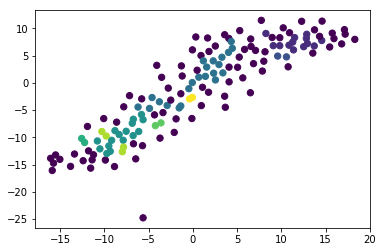

In [85]:
dbscan = cl.DBSCAN(eps=10_000_000_000, min_samples=2, n_jobs=-1).fit(train_books_data)
visualize_data(dbscan.labels_)

Our data is pretty uniformly distributed and DBSCAN is a density-based algorithm, so it works badly on our data:

In [86]:
print_clusters(dbscan.labels_)

=========CLUSTER -1
[]
=========CLUSTER 0
['The Ragged Trousered Philanthropists - Robert Tressell.txt', 'The Count of Monte Cristo - Alexandre Dumas.txt', 'The Foul Ball - By John Irving.txt', 'The Return of Sherlock Holmes - Arthur Conan Doyle.txt', 'The Da Vinci Code - Unknown.txt', 'Memoirs of Sherlock Holmes - SIR ARTHUR CONAN DOYLE.txt', "THE PILGRIM'S PROGRESS - John Bunyan.txt", 'Watership Down.rtf - Darcy.txt', 'Middlemarch - George Eliot.txt', 'The Lost World - SIR ARTHUR CONAN DOYLE.txt', "Salman Rushdie - Midnight's children.txt", 'Great Expectations - Charles Dickens.txt', 'The Moonstone - Wilkie Collins.txt']
=========CLUSTER 1
['Of Mice and Men - John Steinbeck.txt', 'Dracula - by Bram Stoker.txt']
=========CLUSTER 2
['Stephen-King-The-Long-Walk_-1979.txt', 'KANE AND ABEL by JEFFREY ARCHER.txt', '08 Season of Storms (2013) - Stephen Hulin [Kinetic IT].txt', 'EVELYN WAUGH -  MEMORIES OF CAPTAIN CHARLES RYDER.txt', 'Lord of the flies - William Golding.txt', 'GoneWithTheWin

#### Evaluation

* Dbi

In [87]:
results['DBi'].append(davies_bouldin_score(train_books_data, dbscan.labels_))
results['names'].append('DBSCAN')
davies_bouldin_score(train_books_data, dbscan.labels_)

3.794342541451954

* Silhouette coefficient

In [88]:
results['Silhouette coef'].append(silhouette_score(train_books_data, kmeans_pred))
silhouette_score(train_books_data, kmeans_pred)

0.14389059839189547

### Affinity propagation

This algoritm determines so called 'representatives' of each cluster. In our case each cluster has a book that represents all cluster, so that each book in that cluster has something in common with the representative one.

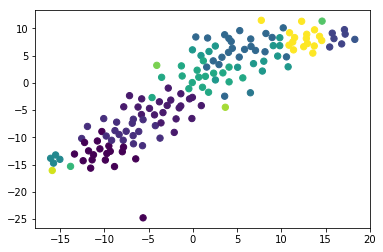

In [89]:
AP = cl.AffinityPropagation().fit(train_books_data)
visualize_data(AP.labels_)

In [90]:
print_clusters(AP.labels_)

=========CLUSTER 0
['Brave New World - Aldous Leonard Huxley.txt', 'Harry Potter and the Prisoner o - J.K. Rowling.txt', 'A Feast For Crows - George R. R. Martin.txt', 'Heidi - Johanna Spyri.txt', "Harry Potter and the Sorcerer's - J.K. Rowling.txt", 'Ulysses - James Joyce.txt', 'Anna Karenina - Leo Tolstoy.txt', 'The Great Gatsby - F. Scott Fitzgerald.txt', 'Fantastic Beasts and Where to F - J. K. Rowling.txt', 'Andrzej Sapkowski - The Witcher 01 The Last Wish - 2007.txt', 'Lee, Harper—To Kill a Mockingbird.txt', 'A Clash of Kings - George R. R. Martin.txt', 'The Thorn Birds - Colleen Mccullough.txt', 'Andrzej_Sapkowski_The_Witcher_06.txt', 'Dan Brown - Origin - 2017.txt', 'Discworld_04_Mort.txt', 'Discworld_26_Thief_of_Time.txt', 'A Storm of Swords - George R. R. Martin.txt', 'Harry Potter and the Goblet of - J.K. Rowling.txt']
=========CLUSTER 1
['Nemesis Games - James S. A. Corey.txt', '08 Season of Storms (2013) - Stephen Hulin [Kinetic IT].txt', 'TheHitchhikersGuideToTheGalaxy - 

#### Evaluation

* Dbi

In [91]:
results['DBi'].append(davies_bouldin_score(train_books_data, AP.labels_))
results['names'].append('Affinity Prop')
davies_bouldin_score(train_books_data, AP.labels_)

1.3117477098125718

* Silhouette coefficient

In [92]:
results['Silhouette coef'].append(silhouette_score(train_books_data, AP.labels_))
silhouette_score(train_books_data, AP.labels_)

0.08854691897869893

### Spectral clusterring

* Create a similarity graph between our N objects to cluster.
* Compute the first k eigenvectors of its Laplacian matrix to define a feature vector for each object.
* Run k-means on these features to separate objects into k classes.


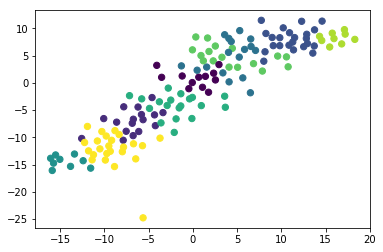

In [93]:
spectral = cl.SpectralClustering(n_clusters=K, affinity='nearest_neighbors').fit(train_books_data)
visualize_data(spectral.labels_)

In [94]:
print_clusters(spectral.labels_)

=========CLUSTER 0
['Stephen-King-The-Long-Walk_-1979.txt', 'KANE AND ABEL by JEFFREY ARCHER.txt', 'Caliban;s war e-2 - James S.A. Corey.txt', 'A CHRISTMAS CAROL By CHARLES DICKENS.txt', 'Stephen-King-Bag-of-Bones_-1998.txt', 'the stand - Stephen King.txt', 'Twenty Thousand Leagues Under t - Jules Verne.txt', "Grimm's Fairy Stories - Unknown.txt", 'David Copperfield - Charles Dickens.txt', 'Alice in Wonderland - Lewis Carroll.txt', '02-Short Stories-The Sword of D - Bradbury.txt', "Hlen Fielding - Bridget Jones's Diary.txt"]
=========CLUSTER 1
['Harry Potter and the Half-Blood - J.K. Rowling.txt', 'Andrzej Sapkowski - The Witcher 04 Time of Contempt - 2013.txt', 'Harry Potter and the Chamber of - J.K. Rowling.txt', 'Nemesis Games - James S. A. Corey.txt', 'A Game Of Thrones - George R. R. Martin.txt', '04 Times of Contempt (1995) - Stephen.txt', '07 The Lady of the Lake (1999) - Stephen Hulin.txt', "Babylon's Ashes - James S. A. Corey.txt", 'Cibola Burn - James S. A. Corey.txt', "Abadd

#### Evaluation

* Dbi

In [95]:
results['DBi'].append(davies_bouldin_score(train_books_data, spectral.labels_))
results['names'].append('Spectral')
davies_bouldin_score(train_books_data, spectral.labels_)

1.97479830914802

* Silhouette coefficient

In [96]:
results['Silhouette coef'].append(silhouette_score(train_books_data, spectral.labels_))
silhouette_score(train_books_data, spectral.labels_)

0.08580473824782002

### Birch
Designed for bid datasets, based on the notion of CF (Clustering Feature),  a CF Tree which is a height balanced tree that stores the clustering features for further hierarchical clustering.

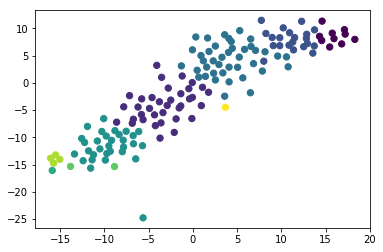

In [97]:
birch = cl.Birch(threshold=0.5, branching_factor=50, n_clusters=9).fit(train_books_data)
visualize_data(birch.labels_)

In [98]:
print_clusters(birch.labels_)

=========CLUSTER 0
['Crime and Punishment - Fyodor Dostoevsky.txt', 'Metamorphosis - Franz Kafka.txt', 'Notes from the Underground - Fyodor Dostoyevsky.txt', 'The Strange Case of Dr. Jekyll - Robert Louis Stevenson.txt', 'Memoirs of Sherlock Holmes - SIR ARTHUR CONAN DOYLE.txt', 'The War of the Worlds by H. G. Wells.txt', 'Holes - Louis Sachar.txt', 'THE JUNGLE by Upton Sinclair.txt', 'Persuasion (Norton Critical Edi - Jane Austen.txt', 'Animal Farm - George Orwell.txt.txt']
=========CLUSTER 1
['Nemesis Games - James S. A. Corey.txt', '08 Season of Storms (2013) - Stephen Hulin [Kinetic IT].txt', 'TheHitchhikersGuideToTheGalaxy - Vladimir Romanov.txt', '04 Times of Contempt (1995) - Stephen.txt', '07 The Lady of the Lake (1999) - Stephen Hulin.txt', "Babylon's Ashes - James S. A. Corey.txt", 'The Provost - John Galt.txt', 'GoneWithTheWind - Shahid Riaz.txt', 'Cibola Burn - James S. A. Corey.txt', "Abaddon's Gate - James S. A. Corey.txt", 'Charlie and the Chocolate Factory - ROALD DAHL.

#### Evaluation

* Dbi

In [99]:
results['DBi'].append(davies_bouldin_score(train_books_data, birch.labels_))
results['names'].append('Birch')
davies_bouldin_score(train_books_data, birch.labels_)

1.2243534611378053

* Silhouette coefficient

In [100]:
results['Silhouette coef'].append(silhouette_score(train_books_data, birch.labels_))
silhouette_score(train_books_data, birch.labels_)

0.15696471673729792

# Models comparison

In [101]:
results

{'DBi': [1.3481235857998475,
  3.794342541451954,
  1.3117477098125718,
  1.97479830914802,
  1.2243534611378053],
 'Silhouette coef': [0.14389059839189547,
  0.14389059839189547,
  0.08854691897869893,
  0.08580473824782002,
  0.15696471673729792],
 'names': ['Kmeans', 'DBSCAN', 'Affinity Prop', 'Spectral', 'Birch']}

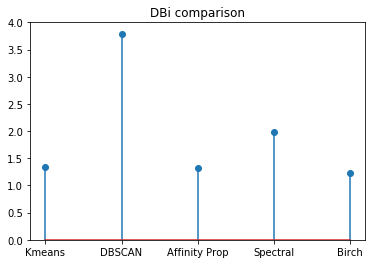

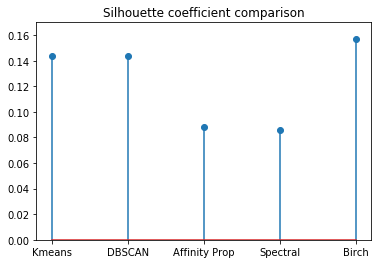

In [102]:
plt.subplots()
plt.title('DBi comparison')
plt.xticks(range(len(results['DBi'])), results['names'])
plt.ylim(0, 4)

plt.stem(results['DBi'])
plt.show()



plt.title('Silhouette coefficient comparison')
plt.xticks(range(len(results['Silhouette coef'])), results['names'])
plt.ylim(0, 0.17)

plt.stem(results['Silhouette coef'])
plt.show()

##### From the plots above:
* __Kmeans__
 
has relatively average performance comparing with others.
 
* __DBSCAN__ 

has the worst performance as density based algorithms do not fit to our data.

* __Affinity propagation__

has relatively average performance comparing with others.

* __Spectral clustering__

has a performance that is slightly lower than average with a bit higher DBi and a bit lower Silhouette score.

* __Birch__ 

has the lowest DBi and the highest Silhouette score, which makes him the best according to chosen metrics.

In reality we should choose an algoritm according to what we need. For example Affinity propagation might be useful because it can choose a "representative" of the cluster, DBSCAN could be useful for data with different densities and Birch is suitable for big datasets.